# Transpilation Technique Comparison

In [257]:
from networkx import barabasi_albert_graph, draw
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp
from qopt_best_practices.transpilation.cost_layer import get_cost_layer
from qiskit.circuit.library import QAOAAnsatz
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization.applications import Maxcut
from qiskit.providers.fake_provider import GenericBackendV2
from qopt_best_practices.qubit_selection import BackendEvaluator
from qiskit.transpiler import Layout
from qiskit.circuit.library import qaoa_ansatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import time
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    Commuting2qGateRouter,
)
from qiskit.transpiler import PassManager
from qopt_best_practices.transpilation.prepare_cost_layer import PrepareCostLayer
from qopt_best_practices.transpilation.swap_cancellation_pass import SwapToFinalMapping
from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit.circuit.library import CXGate
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    HighLevelSynthesis,
    InverseCancellation
)
from qopt_best_practices.transpilation.qaoa_construction_pass import QAOAConstructionPass
from test_annotated_ansatz import annotated_qaoa_ansatz, AnnotatedPrepareCostLayer, AnnotatedCommuting2qGateRouter


In [258]:
def get_problem_qopt(n=4, m=3):
    graph = barabasi_albert_graph(n=n, m=3, seed=42)
    local_correlators = build_max_cut_paulis(graph)
    cost_operator = SparsePauliOp.from_list(local_correlators)
    cost_layer = get_cost_layer(cost_operator)
    return cost_operator, cost_layer, graph

def get_problem_maxcut(n=4, elist = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (2, 3, 1.0)]):
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    # tuple is (i,j,weight) where (i,j) is the edge
    graph.add_weighted_edges_from(elist)
    max_cut = Maxcut(graph)
    qubo = max_cut.to_quadratic_program()
    cost_operator, offset = qubo.to_ising()
    cost_layer = get_cost_layer(cost_operator)
    return cost_operator, cost_layer, graph

def backend_and_layout_a(cost_layer):
    backend = GenericBackendV2(num_qubits = cost_layer.num_qubits, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)
    path_finder = BackendEvaluator(backend)
    path, fidelity, num_subsets = path_finder.evaluate(cost_layer.num_qubits)
    initial_layout = Layout.from_intlist(path, cost_layer.qregs[0])
    return backend, initial_layout


In [259]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
optimal_gamma = 5.11350346
optimal_beta = 5.52673212

# 0. Problem Definition

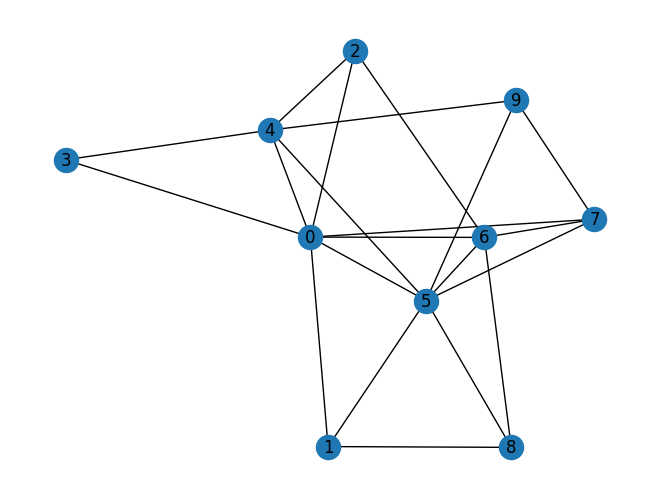

In [260]:
hamiltonian, cost_layer, graph = get_problem_qopt(n=10, m=3)
backend, initial_layout = backend_and_layout_a(cost_layer)
draw(graph, with_labels=True)

# 1. Standard Workflow

In [261]:
qaoa_circuit = qaoa_ansatz(hamiltonian, reps = 1)
qaoa_circuit.draw(fold=-1)

┌───┐                                                                                                                                  ┌────────────┐                                                                                                                                                     
q_0: ┤ H ├─■────────────■────────────■────────────■────────────■─────────────────────────■──────────────────────────────────────■───────────┤ Rx(2*β[0]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├───┤ │ZZ(2*γ[0])  │            │            │            │                         │                                      │           └────────────┘┌────────────┐                                                                                                                                       
q_1: ┤ H ├─■────────────┼────────────┼────────────┼────────────┼─────────────────────────┼────────────■─────────────────────────┼────────────■────────────┤ Rx(2*β[0]) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├───┤              │ZZ(2*γ[0])  │            │            │                         │            │                         │            │            └────────────┘┌────────────┐                                                                                                                         
q_2: ┤ H ├──────────────■────────────┼────────────┼────────────┼────────────■────────────┼────────────┼─────────────────────────┼────────────┼─────────────■────────────┤ Rx(2*β[0]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├───┤                           │ZZ(2*γ[0])  │            │            │            │            │                         │            │             │            ├────────────┤                                                                                                                         
q_3: ┤ H ├───────────────────────────■────────────┼────────────┼────────────┼────────────┼────────────┼────────────■────────────┼────────────┼─────────────┼────────────┤ Rx(2*β[0]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├───┤                                        │ZZ(2*γ[0])  │            │ZZ(2*γ[0])  │            │            │ZZ(2*γ[0])  │            │             │            └────────────┘             ┌────────────┐                                                                                              
q_4: ┤ H ├────────────────────────────────────────■────────────┼────────────■────────────┼────────────┼────────────■────────────┼────────────┼─────────────┼─────────────■─────────────■───────────┤ Rx(2*β[0]) ├──────────────────────────────────────────────────────────────────────────────────────────────
     ├───┤                                                     │ZZ(2*γ[0])               │            │ZZ(2*γ[0])               │            │             │             │ZZ(2*γ[0])   │           └────────────┘                                                    ┌────────────┐                            
q_5: ┤ H ├─────────────────────────────────────────────────────■─────────────────────────┼────────────■─────────────────────────┼────────────┼─────────────┼─────────────■─────────────┼────────────■─────────────■────────────■─────────────────────────■───────────┤ Rx(2*β[0]) ├────────────────────────────
     ├───┤                                                                               │ZZ(2*γ[0])                            │            │             │ZZ(2*γ[0])                 │            │ZZ(2*γ[0])   │            │                         │           └────────────┘┌────────────┐              
q_6: ┤ H ├───────────────────────────────────────────

In [262]:
naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

In [263]:
t0 = time.time()
naive_circuit = naive_pm.run(qaoa_circuit)
t1 = time.time()
print(f"transpilation time: {t1 - t0} (s)")
print(naive_circuit.count_ops())

transpilation time: 6.596477270126343 (s)
OrderedDict([('rz', 99), ('sx', 68), ('cz', 42)])


In [264]:
naive_circuit.draw(fold=-1)

global phase: π
         ┌─────────┐┌────┐┌───────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ┌────┐      ┌────────────────┐   ┌────┐      ┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─■─────────────────────────────────────────────────────────■───■───────────────────────────────────────────────────────────■──■────────────────────────────────────────────────────────────■────────■─────────────────────────────────────────────────────────■──■──────────────────────────────────────────────────────────────────────────■───■──────────────────────────────────────────────────────────────────────────────■────────────■────────────────────────────────────────────────────────────────────────────────────■──────────┤ √X ├──────┤ Rz(π + 2*β[0]) ├───┤ √X ├──────┤ Rz(5π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         └─────────┘└────┘└───────┘ │                                                         │   │                                                           │  │                                                            │        │                                                         │  │                                                                          │   │                                                                              │            │         ┌─────────┐  ┌────┐   ┌───────┐   ┌────────────┐    ┌────┐    ┌───────┐    │          └────┘      └────────────────┘   └────┘      └──────────┘                                                                                                       ┌────┐   ┌───────┐┌────────────┐┌────┐┌───────┐      ┌────┐┌───────┐┌────────────┐┌────┐┌───────┐   ┌────┐┌───────┐                                                                                                                                                ┌────┐      ┌────────────────┐   ┌────┐   ┌──────────┐
q_7 -> 1 ───────────────────────────┼─────────────────────────────────────────────────────────┼───┼───────────────────────────────────────────────────────────┼──┼────────────────────────────────────────────────────────────┼────────┼─────────────────────────────────────────────────────────┼──┼──────────────────────────────────────────────────────────────────────────┼───┼──────────────────────────────────────────────────────────────────────────────┼────────────■─────────┤ Rz(π/2) ├──┤ √X ├───┤ Rz(π) ├───┤ Rz(2*γ[0]) ├────┤ √X ├────┤ Rz(π) ├────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├───┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(π) ├─■──■─┤ √X ├┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π) ├───────────────────────────────────────────────────

## Expectation Value:

In [265]:
isa_hamiltonian = hamiltonian.apply_layout(naive_circuit.layout)
expectation_naive = estimator.run([(naive_circuit, isa_hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
expectation_naive

dict_values([array(-0.0761462), array(0.)])

# 2. QOPT Workflow

In [266]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(cost_layer.num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(cost_layer.num_qubits)}

# 2. define pass manager for cost layer
pre_init_qopt = PassManager(
    [
        PrepareCostLayer(),
        Commuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        # HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        # InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)

# 3. define building PM
init_qopt = PassManager([QAOAConstructionPass(num_layers=1)])

In [267]:
qopt_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
qopt_pm.pre_init = pre_init_qopt
qopt_pm.init = init_qopt

In [268]:
t0_opt = time.time()
qopt_circuit = qopt_pm.run(cost_layer)
t1_opt = time.time()
print(f"transpilation time: {t1_opt - t0_opt} (s)")
print(qopt_circuit.count_ops())

transpilation time: 0.005514860153198242 (s)
OrderedDict([('sx', 247), ('rz', 200), ('cz', 115), ('measure', 10), ('x', 4)])


In [269]:
qopt_circuit.draw(fold=-1)

global phase: 7π/4
         ┌─────────┐┌────┐┌───────────┐         ┌────┐  ┌────────┐                                  ┌────┐  ┌─────────┐            ┌───┐                                                                                                                                                                                                                                                                   ┌──────────┐    ┌────┐                     ┌────┐                                        ┌─────────┐       ┌────┐    ┌───────────┐                                                                                                                          ┌────┐                ┌────┐                                       ┌──────────┐    ┌────┐   ┌──────────────┐                                                                                                                                   ┌────┐                              ┌────┐    ┌──────────┐                  ┌───┐                                                                                                                                                                                                                                                                                                 ┌─────────┐          ┌────┐      ┌────────────────┐      ┌────┐         ┌──────────┐                              ┌─┐         
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(1.907) ├────■────┤ √X ├──┤ Rz(-π) ├─────────────────────────────■────┤ √X ├──┤ Rz(π/2) ├──────────■─┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(-π/2) ├────┤ √X ├───────────────■─────┤ √X ├────────────────────────────────────■───┤ Rz(π/2) ├───────┤ √X ├────┤ Rz(-3π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ √X ├────────────■───┤ √X ├────────────────────────────────────■──┤ Rz(-π/2) ├────┤ √X ├───┤ Rz(-0.65108) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├─────────────────────────■────┤ √X ├────┤ Rz(-π/2) ├─────────────■────┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────■────┤ Rz(π/2) ├──────────┤ √X ├──────┤ Rz(π + 2*β[0]) ├──────┤ √X ├─────────┤ Rz(5π/2) ├──────────────────────────────┤M├─────────
         └┬────────┤├────┤└┬─────────┬┘    │    ├────┤  └────────┘    ┌────┐                   │ ┌──┴────┴─┐└──┬────┬─┘┌───────┐ │ └───┘                                                                                                                                                                                                                           ┌────┐     ┌──────────┐┌────────────┐ │ └──┬────┬──┘ ┌──┴────┴──┐            │     ├────┤                           ┌────┐   │ ┌─┴─────────┴─┐     ├────┤    └───────────┘                                                                                       ┌────┐               ┌────┐      │ └────┘┌─────────┐ │   ├────┤  ┌───────┐                         │  └──────────┘    └────┘   └──────────────┘                                                                                                                  ┌────┐    │   ┌──┴────┴─┐  ┌────────────┐┌────┐ │ ┌──┴────┴──┐ └──────────┘    ┌────┐   │    └───┘                        ┌────┐  ┌─────────────┐   ┌────┐                                                                                                                                                       │       ┌────┐       ┌───────┐  ┌────────

## Expectation Value:

In [270]:
qopt_circuit.remove_final_measurements()
isa_hamiltonian = hamiltonian.apply_layout(qopt_circuit.layout)

expectation_qopt = estimator.run([(qopt_circuit, isa_hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
expectation_qopt

dict_values([array(-0.0761462), array(0.)])

# 3. Annotated Workflow

AM I PRINTING
USE BOX
AM I PRINTING
USE BOX


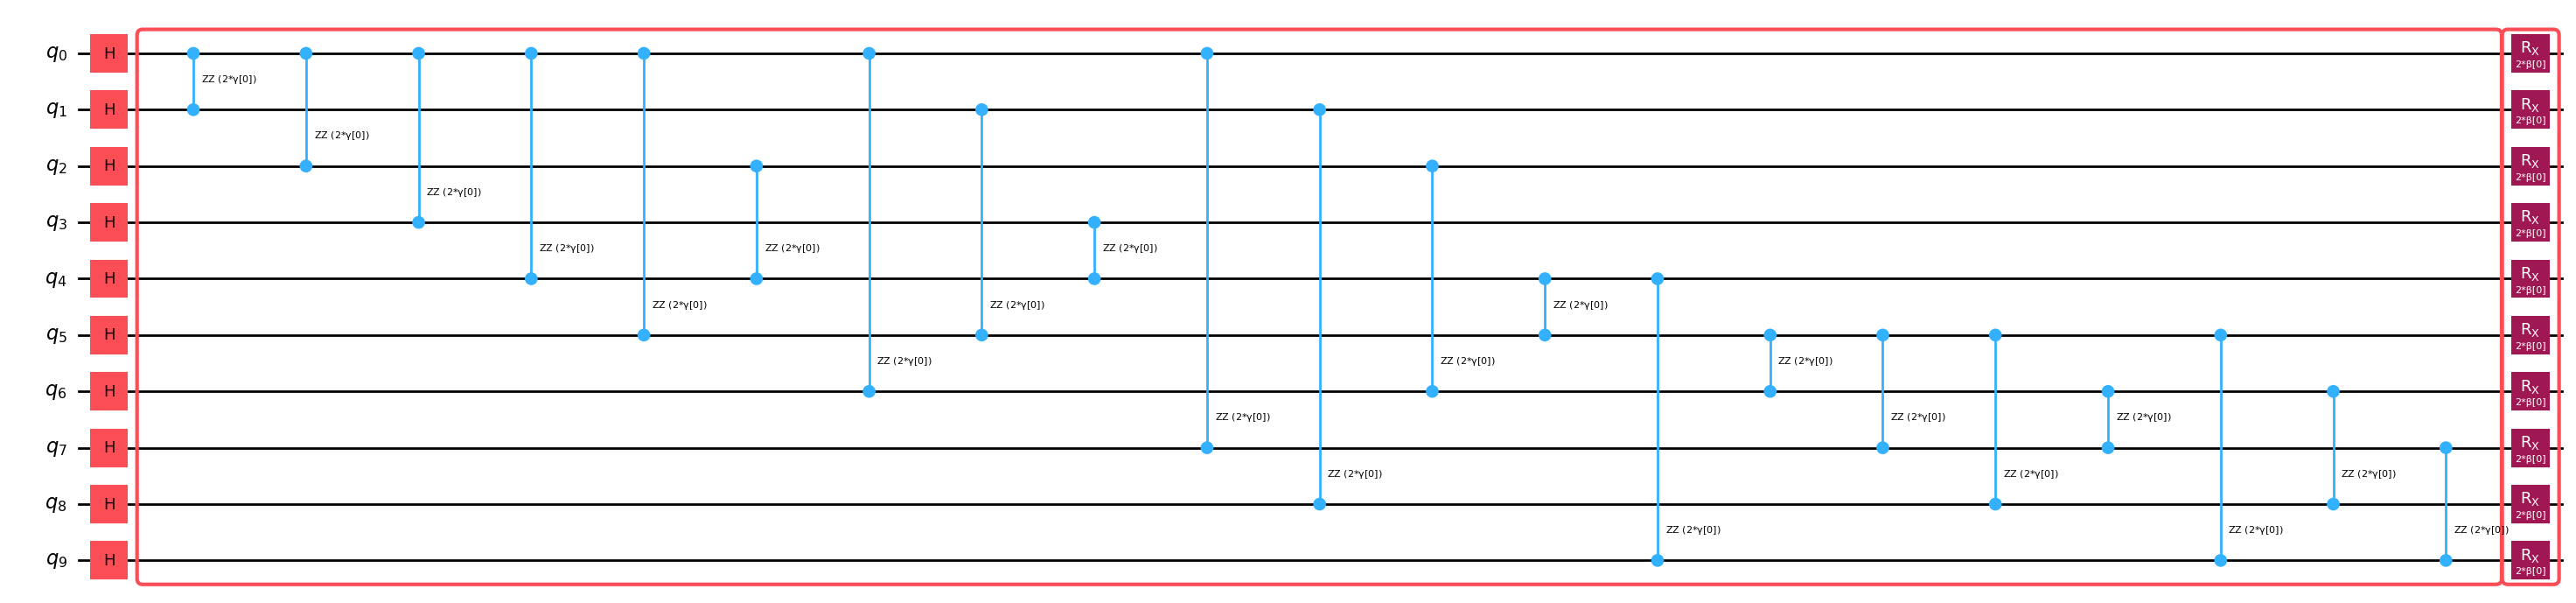

In [271]:
annotated_ansatz = annotated_qaoa_ansatz(hamiltonian, reps = 1)
annotated_ansatz.draw('mpl', fold=-1)

In [272]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(cost_layer.num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(cost_layer.num_qubits)}

# 2. define pass manager for cost layer
pre_init_a = PassManager(
    [
        AnnotatedPrepareCostLayer(),
        AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        # HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        # InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)
init_a = PassManager([])

In [273]:
annotated_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
annotated_pm.pre_init = pre_init_a
annotated_pm.init = init_a

In [274]:
t0_opt = time.time()
annotated_circuit = annotated_pm.run(annotated_ansatz)
t1_opt = time.time()
print(f"transpilation time: {t1_opt - t0_opt} (s)")
print(annotated_circuit.count_ops())

GATE LAYERS defaultdict(<class 'dict'>, {np.int64(0): {(0, 1): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x136a90750>]), (3, 4): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x137070270>]), (4, 5): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x137070150>]), (5, 6): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x137070030>]), (6, 7): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x137029c50>])}, np.int64(8): {(0, 2): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x136a90090>]), (5, 8): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._a

In [275]:
annotated_circuit.draw(fold=-1)

global phase: π/4
         ┌─────────┐┌────┐┌───────────┐         ┌────┐  ┌────────┐                                  ┌────┐  ┌─────────┐            ┌───┐                                                                                                                                                                                                                                                                   ┌──────────┐    ┌────┐                     ┌────┐                                        ┌─────────┐       ┌────┐    ┌───────────┐                                                                                                                          ┌────┐                ┌────┐                                       ┌──────────┐    ┌────┐   ┌──────────────┐                                                                                                                                      ┌────┐                              ┌────┐    ┌──────────┐                   ┌───┐                                                                                                                                                                                                                                                   ┌─────────┐          ┌────┐      ┌────────────────┐      ┌────┐      ┌──────────┐            
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(1.907) ├────■────┤ √X ├──┤ Rz(-π) ├─────────────────────────────■────┤ √X ├──┤ Rz(π/2) ├──────────■─┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(-π/2) ├────┤ √X ├───────────────■─────┤ √X ├────────────────────────────────────■───┤ Rz(π/2) ├───────┤ √X ├────┤ Rz(-3π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ √X ├────────────■───┤ √X ├────────────────────────────────────■──┤ Rz(-π/2) ├────┤ √X ├───┤ Rz(-0.65108) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├─────────────────────────■────┤ √X ├────┤ Rz(-π/2) ├─────────────■─────┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────■────┤ Rz(π/2) ├──────────┤ √X ├──────┤ Rz(π + 2*β[0]) ├──────┤ √X ├──────┤ Rz(5π/2) ├────────────
         └┬────────┤├────┤└┬─────────┬┘    │    ├────┤  └────────┘    ┌────┐                   │ ┌──┴────┴─┐└──┬────┬─┘┌───────┐ │ └───┘                                                                                                                                                                                                                           ┌────┐     ┌──────────┐┌────────────┐ │ └──┬────┬──┘ ┌──┴────┴──┐            │     ├────┤                           ┌────┐   │ ┌─┴─────────┴─┐     ├────┤    └───────────┘                                                                                       ┌────┐               ┌────┐      │ └────┘┌─────────┐ │   ├────┤  ┌───────┐                         │  └──────────┘    └────┘   └──────────────┘                                                                                                                    ┌────┐     │   ┌──┴────┴─┐  ┌────────────┐┌────┐ │ ┌──┴────┴──┐ └──────────┘    ┌────┐   │     └───┘                     ┌────┐┌─────────────┐   ┌────┐                                                                                                              │                                       ┌────┐     ┌───────┐  ┌────────────┐ │    └──┬────┬─┘          └────┘      ├────────────────┤      ├────┤      ├──────────┤            
q_9 -> 1 ─┤ Rz(-π) ├┤ √X ├─┤ Rz(π/2) ├──■──┼────┤ √X ├────

## Expectation Value:

In [276]:
isa_hamiltonian = hamiltonian.apply_layout(annotated_circuit.layout)
expectation_annotated = estimator.run([(annotated_circuit, isa_hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
expectation_annotated

dict_values([array(-0.0761462), array(0.)])

# EXPECTATION VALUE COMPARISON

In [277]:
print("NUM QUBITS:", annotated_circuit.num_qubits)

NUM QUBITS: 10


In [278]:
expectation_naive

dict_values([array(-0.0761462), array(0.)])

In [279]:
expectation_qopt

dict_values([array(-0.0761462), array(0.)])

In [280]:
expectation_annotated

dict_values([array(-0.0761462), array(0.)])

# PASS COMPARISON

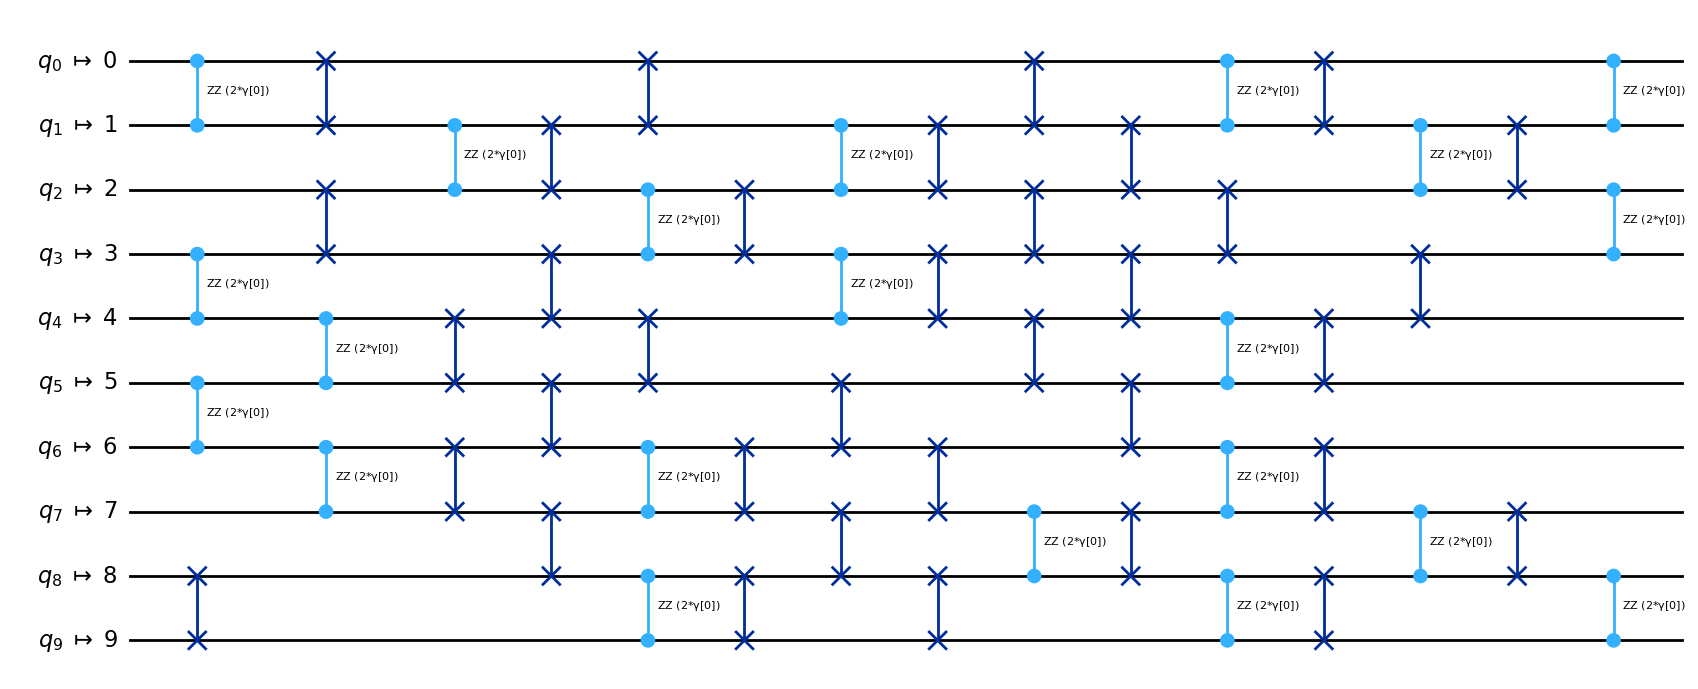

In [281]:
out_qopt = pre_init_qopt.run(cost_layer)
out_qopt.draw('mpl', fold=-1)

layout not found, assigining trivial layout


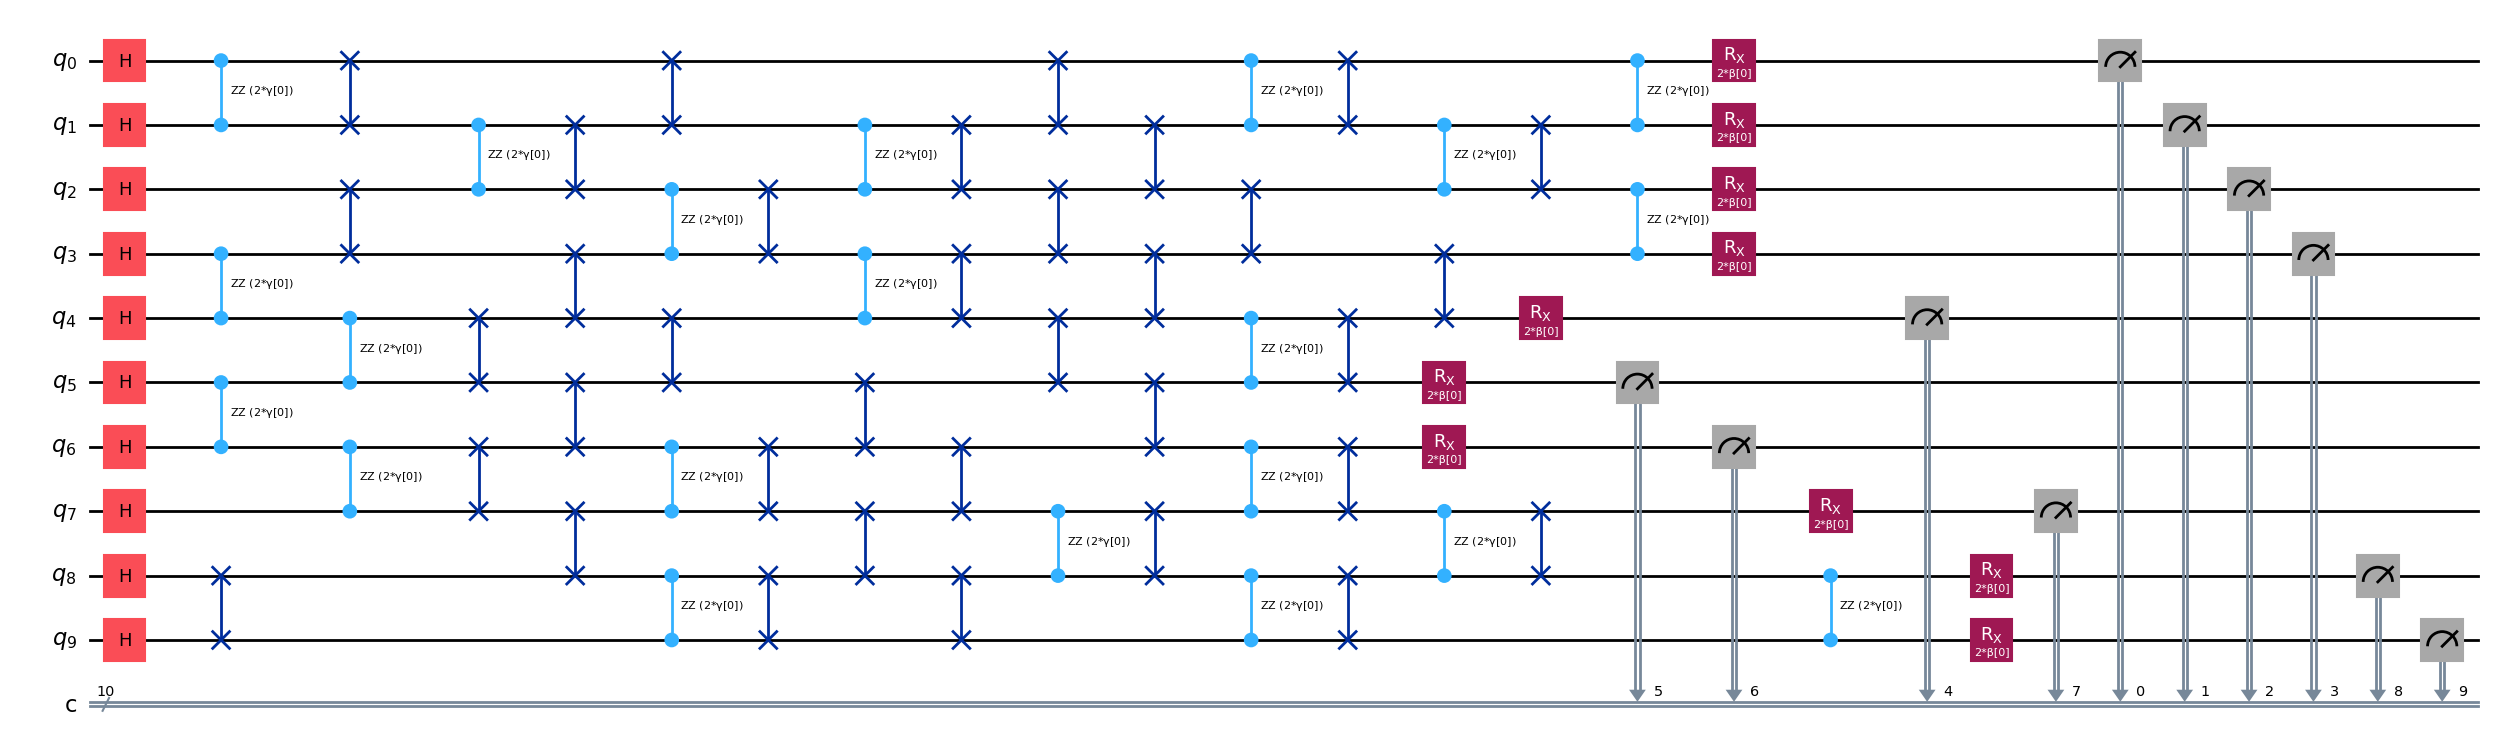

In [282]:
out_qopt_full = init_qopt.run(out_qopt)
out_qopt_full.draw('mpl', fold=-1)

In [283]:
new_pre_init_qopt = PassManager(
    [
        PrepareCostLayer(),
        Commuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        # HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        # InverseCancellation(gates_to_cancel=[CXGate()]),
        QAOAConstructionPass(num_layers=1)
    ]
)

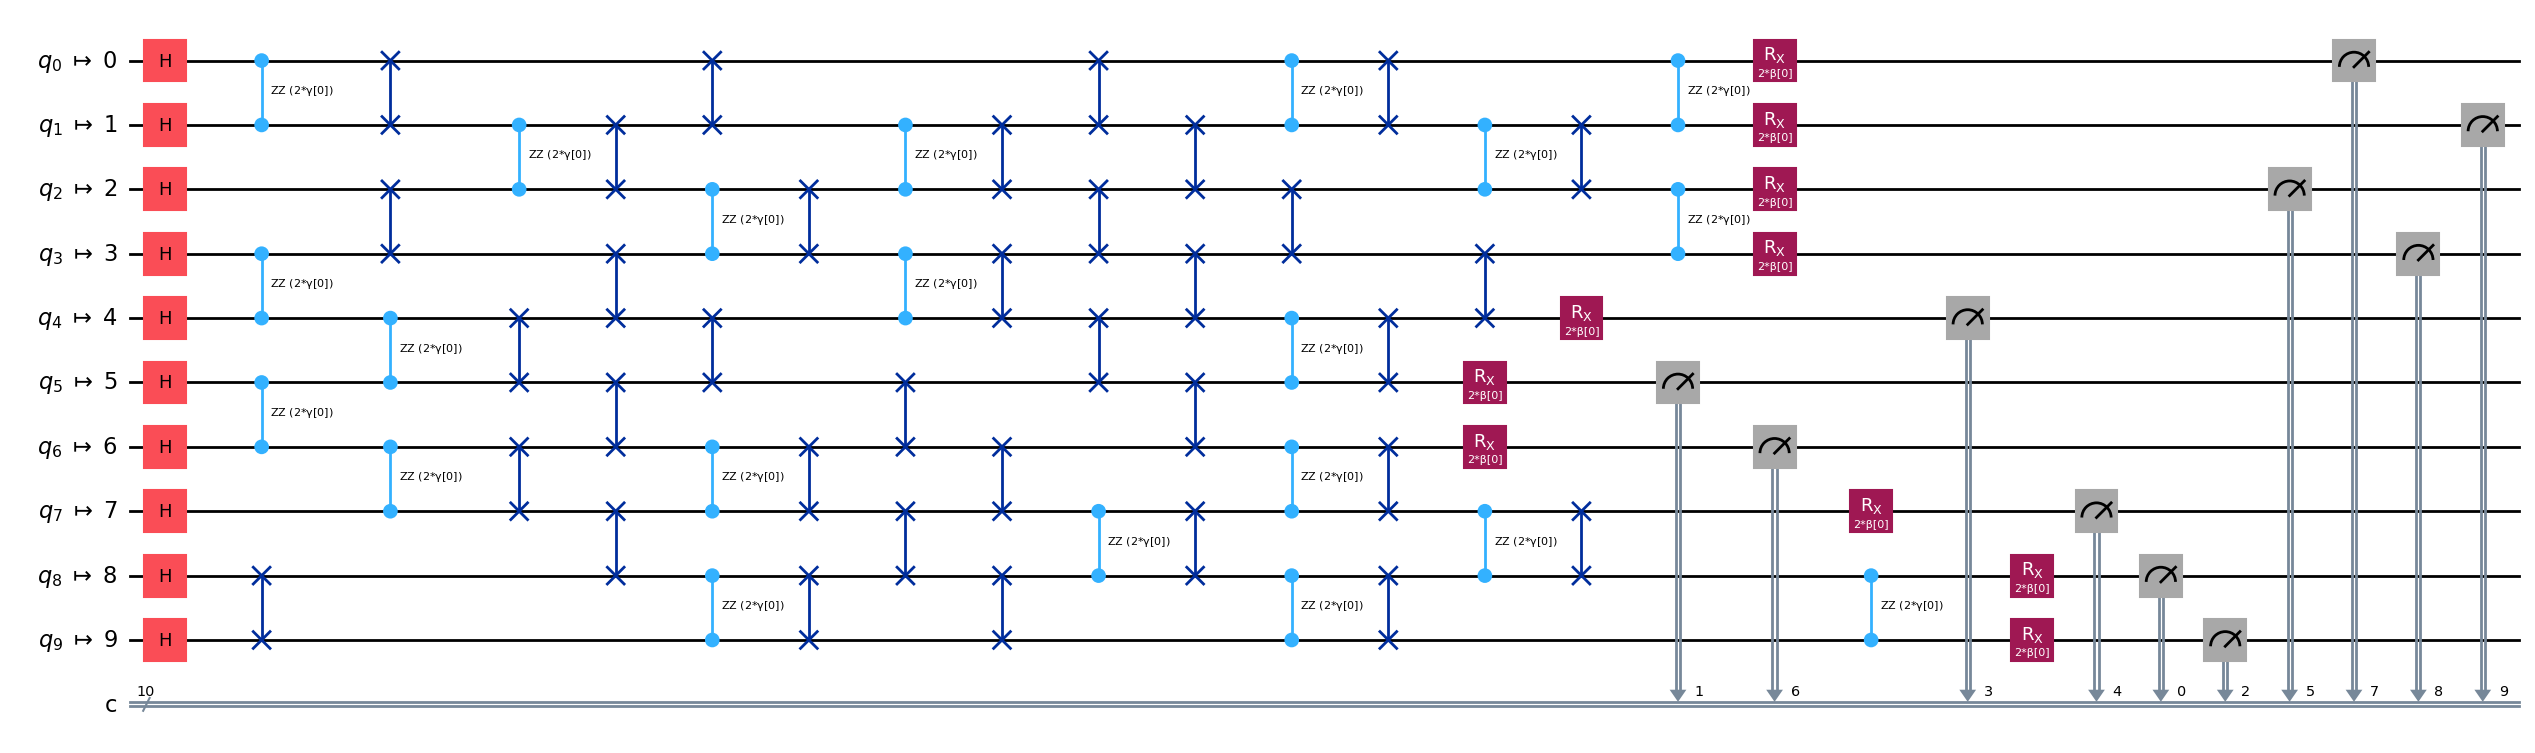

In [284]:
out_qopt = new_pre_init_qopt.run(cost_layer)
out_qopt.draw('mpl', fold=-1)

GATE LAYERS defaultdict(<class 'dict'>, {np.int64(0): {(0, 1): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x369297690>]), (3, 4): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x3bc446910>]), (4, 5): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x3bc4474b0>]), (5, 6): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x3bc446730>]), (6, 7): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x3bc4476f0>])}, np.int64(8): {(0, 2): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x3bc446b50>]), (5, 8): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._a

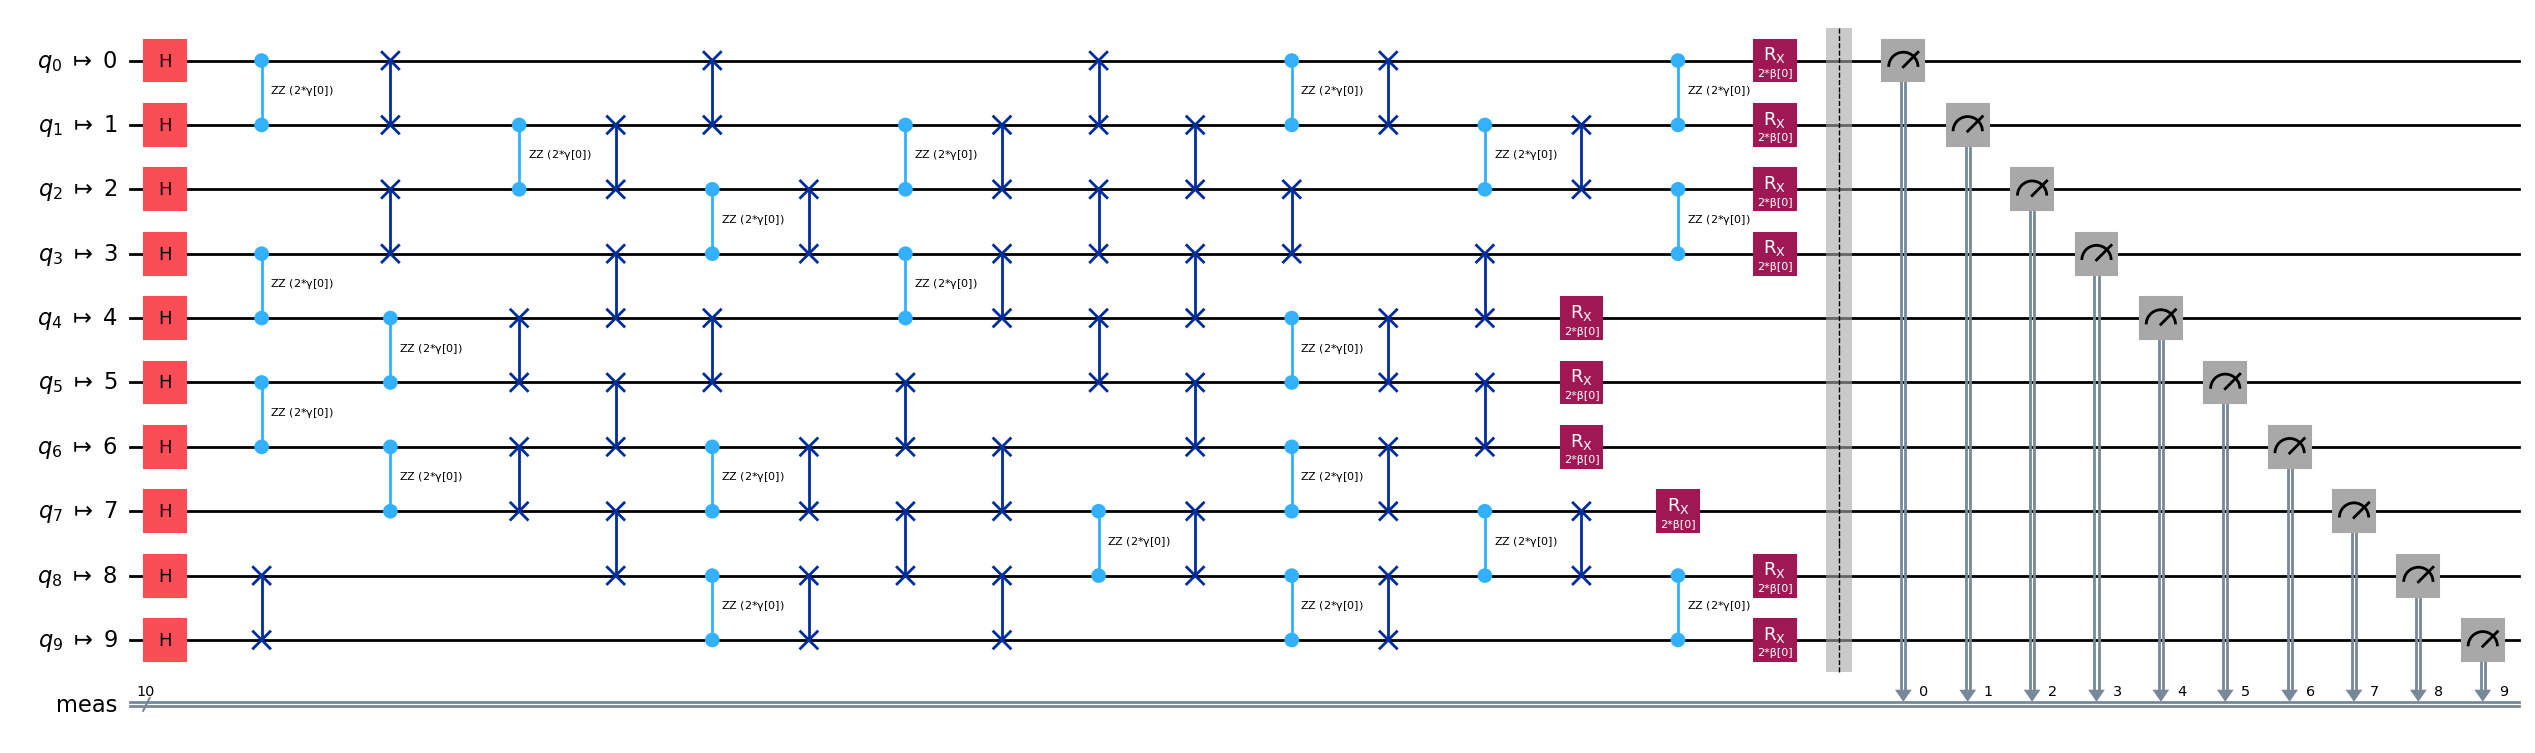

In [285]:
out_annot = pre_init_a.run(annotated_ansatz)
out_annot.measure_all()
out_annot.draw('mpl', fold=-1)